In [1]:
%run stdPackages.ipynb

## 1. Set up and solve model

Input data covers:
* Data on worker-to-retiree ratios $\nu_t$
* Set $X_i = A_t = 1$ for now (consider whether we need this for other calibration purposes).
* Set $\alpha$ to measure factor income shares.
* Set $\xi$ to reflect Frisch elasticity (measured as individual response to after-tax wages).
* $\epsilon$ from the minimum pension relative to "full". $\theta$ from replacement rates.
* Estimate of income distribution $(\gamma_i, \eta_i)$.
* Set $\beta_i$ to reflect distribution in savings rates across the income distribution / MPC's across the income distribution.

In [2]:
dates = pd.Index([1950, 1980, 2010, 2040, 2070, 2100], name = 't')
ν = np.array([1.497025777, 1.365562914, 1.20756547, 1.110843373, 1.072547602, 1.0725])
T = len(ν)
A = np.ones(T)
α = .5
ξ = .35
epsilon = .56
θ = .815

Data on inequality (from World Inequality Database on Argentina): 
* Split into top 10%, middle 40%, and bottom 50%
* Top has 43.6%, middle has 42.8% bottom has 13.6%, 

In [3]:
γ = np.array([0.5, 0.4, 0.1])
ni = len(γ)
X = np.ones(ni)

Share of income in 2010:

In [4]:
shareOfIncome = np.array([.136, 0.428, .436])
η = np.power(shareOfIncome/γ, 1/(1+ξ))*np.power(X, ξ/(1+ξ)) 

(This normalizes $\Gamma =1$ by the way.)

To identify the distribution of $\beta_i$, we use that $\beta_i/(1+\beta_i)$ is the savings rate out of labor income (income when young, generally). Assume that we have savings rates across the income distribution:

In [5]:
# sRates = np.array([0.05, 0.22, 0.35]) 
sRates = np.array([.207, .207, .207]) # uniform beta
β = sRates/(1-sRates)

For, now just assume something about the "unemployed":

In [6]:
γu=.1
χ1=min(η)*.5
χ2=χ1*.5
βu= min(β)*.75 

We initialize the model with parameter values by calling:

In [7]:
model = vectorized.infHorizon(ni = ni, T = T, **{'α': α, 'A': A, 'ν': ν, 'η': η, 'γ': γ, 'X': X, 'β': β, 'βu': βu, 'ξ': ξ, 'epsilon': epsilon, 'θ': θ, 'γu': γu, 'χ1': χ1, 'χ2': χ2})

Target a specific tax rate (e.g. in 14.2% in 2010):

In [8]:
τ0 = 0.142
t0 = dates.get_loc(2010)
model.calibrateω(τ0, t0, x0 = 1) 

array([1.85468276])

Store the solution including various other helpful variables in the ```self.database``` by calling:

In [9]:
model.reportAll()

## 2 Experiments:

Provide some labels to call the $i$ types when plotting:

In [10]:
typeLabels = {0: 'Low income', 1: 'Middle income', 2: 'High income'}

Auxiliary functions used for plotting:

In [11]:
def addYears(x, copy = True):
    """ Replace integer set 't' (from 0 to T) with years in 'dates' """
    if copy:
        x = x.copy()
    if isinstance(x, pd.Index):
        return x.map(pd.Series(dates.values, index = model.db['t'])).rename('')
    elif isinstance(x, (pd.DataFrame, pd.Series)):
        x.index = addYears(x.index, copy = False)
        return x
def adjLabels(x, copy = True):
    """ Replace integer set 'i' (from 0 to ni) with labels in 'typeLabels' """
    if copy:
        x = x.copy()
    if isinstance(x, pd.Index):
        return x.map(typeLabels)
    elif isinstance(x, pd.Series):
        x.index = adjLabels(x.index, copy = False)
    elif isinstance(x, pd.DataFrame):
        x.columns = adjLabels(x.columns, copy = False)
    return x

Store variables across a parameter shock:

In [12]:
def extractDf(sol, x, grid):
    return addYears(pd.concat([soli[x] for soli in sol.values()], axis=1)).set_axis(grid, axis = "columns")

Store initial values before experiments:

In [13]:
initialSolution = model.db.copy() # default values to start experiments from

*Vary $\epsilon$ and report solution:*

In [14]:
ϵgrid = pd.Index([round(x,1) for x in np.linspace(0,1,11)], name = '$\epsilon$')
ϵsol = dict.fromkeys(ϵgrid)
for ϵ in ϵgrid:
    model.updateAndSolve(**{'epsilon': ϵ})
    model.reportAll()
    ϵsol[ϵ] = model.db.copy()

*Vary $\theta$ and report solution:*

In [214]:
model.db = initialSolution.copy() # reset to starting values
θgrid = pd.Index([round(x,1) for x in np.linspace(0,1,11)], name = '$\\theta$')
θsol = dict.fromkeys(θgrid)
for θ in θgrid:
    model.updateAndSolve(**{'θ': θ})
    model.reportAll()
    θsol[θ] = model.db.copy()

## 3. Illustrations

### 3.1. PEE taxes as a function of pension design

Extract solution for $\tau_t$ for the different values of $\epsilon$ and $\theta$:

In [16]:
τϵ = extractDf(ϵsol, 'τ', ϵgrid)
τθ = extractDf(θsol, 'τ', θgrid)

Plot $\tau_t$ as a function of $\theta$ and $\epsilon$:

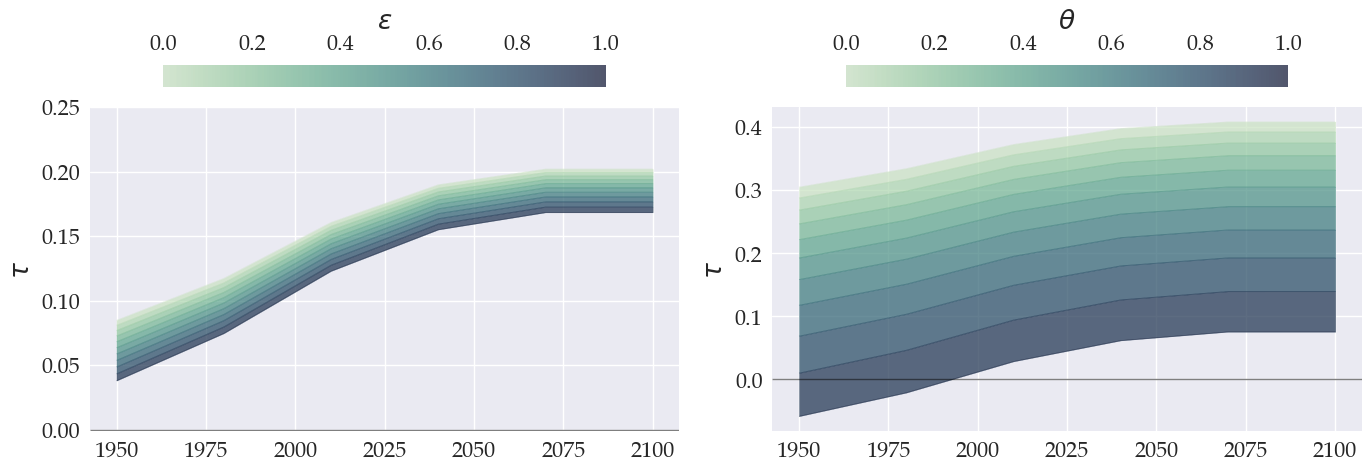

In [210]:
mult_graphs()
# Specify color map:
palette, mapAlpha = 'ch:start=.1,rot=-.5', .75
colormap = add_alpha_to_colormap(seaborn.color_palette(palette, as_cmap=True), alpha = mapAlpha)

# Create plot:
fig, axes = plt.subplots(1, 2, figsize = (14, 5));
ax = plt.subplot(1,2,1)
seaborn.lineplot(data = τϵ, linewidth = .25, dashes=False, palette = palette, ax = ax, alpha = .75, legend = False);
for i in range(τϵ.shape[1]-1):
    ax.fill_between(τϵ.index, τϵ.iloc[:,i], τϵ.iloc[:,i+1], alpha = mapAlpha, color = ax.get_lines()[i].get_color())
dfAx(ax, .25, ylabel = '$\\tau$');
sm = plt.cm.ScalarMappable(cmap = colormap, norm = plt.Normalize(min(ϵgrid), max(ϵgrid)))
cbar = ax.figure.colorbar(sm, ax = ax, location = 'top', shrink = .75);
cbar.set_label('$\epsilon$');

ax = plt.subplot(1,2,2)
seaborn.lineplot(data = τθ, linewidth = .25, dashes=False, ax = ax, palette = palette, alpha = .75, legend = False);
for i in range(τθ.shape[1]-1):
    ax.fill_between(τθ.index, τθ.iloc[:,i], τθ.iloc[:,i+1], alpha = mapAlpha, color = ax.get_lines()[i].get_color())
dfAx(ax, .25, ylabel = '$\\tau$')
sm = plt.cm.ScalarMappable(cmap = colormap, norm = plt.Normalize(min(θgrid), max(θgrid)))
cbar = ax.figure.colorbar(sm, ax = ax, location = 'top', shrink = .75);
cbar.set_label('$\\theta$');

fig.tight_layout()

### 3.2. Utility as a function pension design

Report the level of utility as a function of $\epsilon, \theta$ relative to the baseline calibration. We do this for the baseline year $2010$. Report for the four different types: Workers (split into $i$ productivity types), retirees (split into $i$ productivity types), young hand-to-mouth consumers, and old hand-to-mouth consumers.

*1. Young workers:*

In [239]:
u0 = adjLabels(initialSolution['util1i']).xs(t0) # initial levels of utility
uRelative_ϵ = 100 * pd.concat([adjLabels(soli['util1i']).xs(t0) for soli in ϵsol.values()],axis=1).set_axis(ϵgrid, axis = "columns").div(u0,axis=0).T
uRelative_θ = 100 *pd.concat([adjLabels(soli['util1i']).xs(t0) for soli in θsol.values()],axis=1).set_axis(θgrid, axis = "columns").div(u0,axis=0).T

Plot:

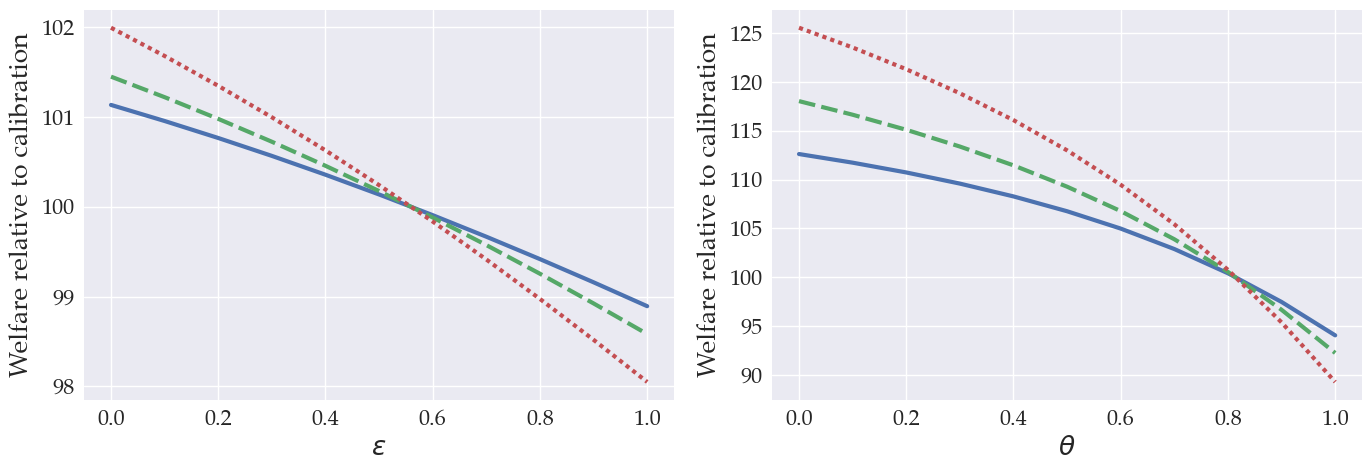

In [244]:
mult_graphs()
fig, axes = plt.subplots(1, 2, figsize = (14, 5));
ax = plt.subplot(1,2,1)
seaborn.lineplot(data = uRelative_ϵ, linewidth = 3, ax = ax, legend = False);
ax.set_ylabel('Welfare relative to calibration');
ax = plt.subplot(1,2,2)
seaborn.lineplot(data = uRelative_θ, linewidth = 3, ax = ax, legend = False);
ax.set_ylabel('Welfare relative to calibration');
fig.tight_layout()